**Numbers Recognition with Convolutional Neural Networks**


---


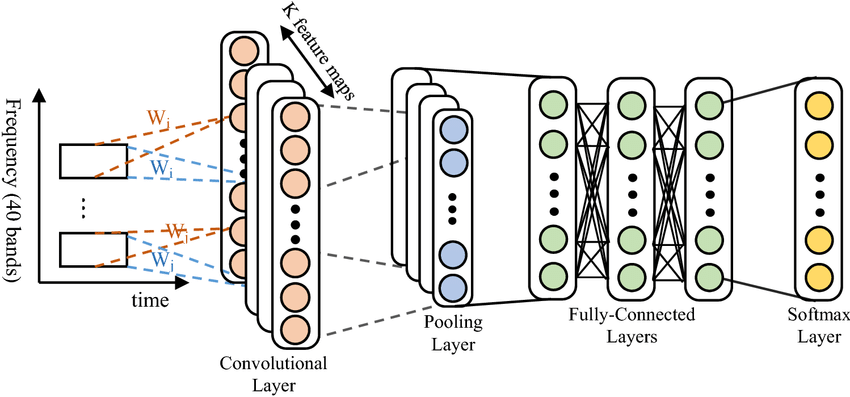

This project involves developing a Convolutional Neural Network (CNN) to recognize speech commands from audio files. The audio data is processed into Mel spectrograms, which are then fed into the CNN model for classification. The primary goal is to achieve high accuracy in recognizing simple spoken digits (e.g., 'one', 'two', 'three', etc.).



# Libraries Importing

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
import itertools
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from keras.utils import plot_model
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.io import wavfile
from keras.utils import to_categorical
import keras.backend as k
from matplotlib import pyplot
import warnings
warnings.filterwarnings ('ignore')

In [ ]:
Labels = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Data Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all_wave = []
all_label = []

# Exeploratory Data Analysis (**EDA**)

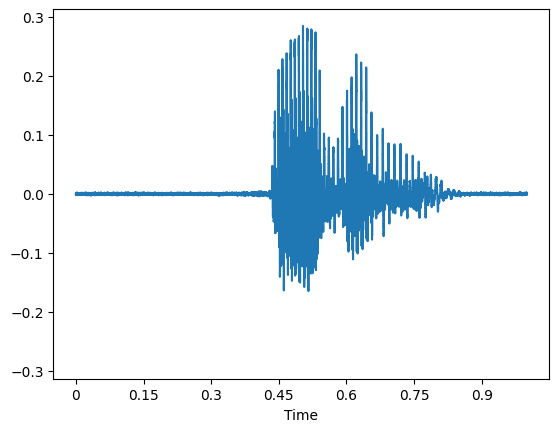

In [ ]:
array, sample_rate = librosa.load('/content/drive/MyDrive/test/audio/clip_00d92e846.wav', sr=8000)
librosa.display.waveshow(array, sr=8000)

(128, 16)


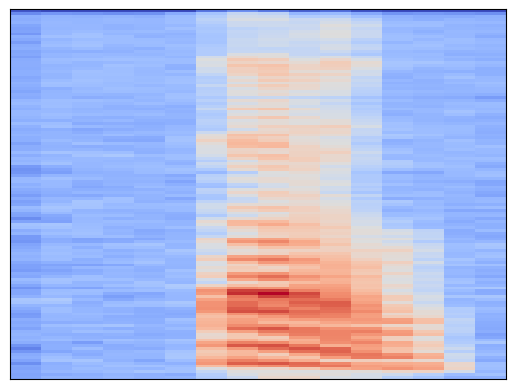

In [ ]:
array, sample_rate = librosa.load('/content/drive/MyDrive/test/audio/clip_00d92e846.wav', sr=8000)

spect = librosa.feature.melspectrogram(y=array, sr=sample_rate)
log_spect = librosa.power_to_db(spect, ref=np.max)
normalized_spect = z_score_normalize(log_spect)


librosa.display.specshow(normalized_spect, sr=8000)
print(normalized_spect.shape)

# Problems Faced & Solutions.

1. I tried to train the model on the **waveform** representation, but this wasn't the best feature-extracting form so the model at its highest performance was on 70% validation accuracy.

    - solved this problem by converting the waveform to **Mel spectrogram** this way more better

2. CNN needs the data to be normalized and without it, the efficiency of the training will be low.

    - solved this problem by applying the most suitable normalization fro this case and it was **Z score Normalization**


In [ ]:
def z_score_normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

In [ ]:
for label in Labels:
  print(label)
  waves = [f for f in os.listdir('/content/drive/MyDrive/train/audio/' + label) if f.endswith('.wav')]
  for wav in waves:
    array, sample_rate = librosa.load('/content/drive/MyDrive/train/audio' + '/' + label +'/' + wav, sr=8000)
    if len(array) == 8000:
      spect = librosa.feature.melspectrogram(y=array, sr=sample_rate)
      log_spect = librosa.power_to_db(spect, ref=np.max)
      normalized_spect = z_score_normalize(log_spect)
      all_wave.append(normalized_spect)
      all_label.append(label)

one
two
three
four
five
six
seven
eight
nine


# Label Encoding & One hot Encoding

In [ ]:
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)
classes

['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two']

In [ ]:
y = to_categorical(y, num_classes=len(classes))
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Data Spliting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(all_wave), np.array(y), test_size=0.2,shuffle=True,random_state=777,stratify=y)

# Building CNN Model

In [ ]:
k.clear_session()

In [ ]:
#Creating Input layer
inputs = layers.Input(shape=(128,16))
inputs

<KerasTensor: shape=(None, 128, 16) dtype=float32 (created by layer 'input_1')>

In [ ]:

#Creating 4 Layers
conv = Conv1D(8,13,padding='valid',activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(16,11,padding='valid',activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(32,9,padding='valid',activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(64,7,padding='valid',activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

In [ ]:
#Creating Flatten layer
conv = Flatten()(conv)
#Creating 2 Dense Layers
conv = Dense(256,activation='relu')(conv)
conv = Dropout(0.3)(conv)
conv = Dense(128,activation='relu')(conv)
conv = Dropout(0.3)(conv)
#Creating Output Layer
outputs = Dense(len(Labels),activation='softmax')(conv)


In [ ]:
model = models.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 16)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 122, 64)           7232      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 40, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 40, 64)            0         
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                             

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training


*   Set **Early setup** & **Model Checkpoint**
*   Store the epochs' **loss** and **accuracy** in **history**



In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,restore_best_weights=True, min_delta=0.0001)

mc = callbacks.ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

history = model.fit(x_train,y_train,epochs=100,callbacks=[es,mc],validation_data=(x_test,y_test),batch_size=32)


Epoch 1/100
482/484 [============================>.] - ETA: 0s - loss: 1.4064 - accuracy: 0.4891
Epoch 1: val_accuracy improved from -inf to 0.74742, saving model to best_model.h5
484/484 [==============================] - 4s 5ms/step - loss: 1.4045 - accuracy: 0.4898 - val_loss: 0.7623 - val_accuracy: 0.7474
Epoch 2/100
480/484 [============================>.] - ETA: 0s - loss: 0.8867 - accuracy: 0.6934
Epoch 2: val_accuracy improved from 0.74742 to 0.82515, saving model to best_model.h5
484/484 [==============================] - 2s 5ms/step - loss: 0.8839 - accuracy: 0.6945 - val_loss: 0.5394 - val_accuracy: 0.8252
Epoch 3/100
483/484 [============================>.] - ETA: 0s - loss: 0.7490 - accuracy: 0.7429
Epoch 3: val_accuracy improved from 0.82515 to 0.84969, saving model to best_model.h5
484/484 [==============================] - 2s 5ms/step - loss: 0.7488 - accuracy: 0.7429 - val_loss: 0.4944 - val_accuracy: 0.8497
Epoch 4/100
484/484 [==============================] - ETA: 0

# Ploting History and Model Saving

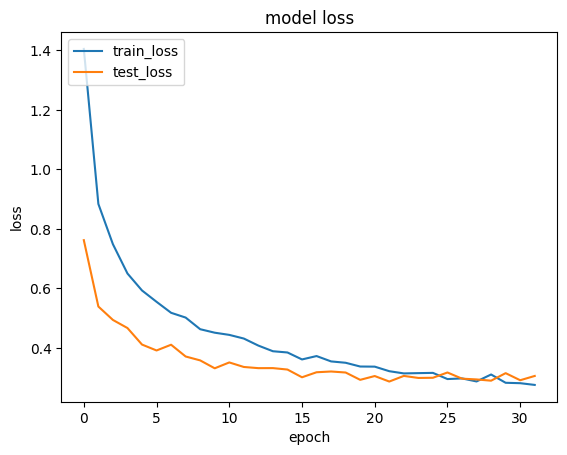

In [ ]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train_loss', 'test_loss'], loc='upper left')
pyplot.show()

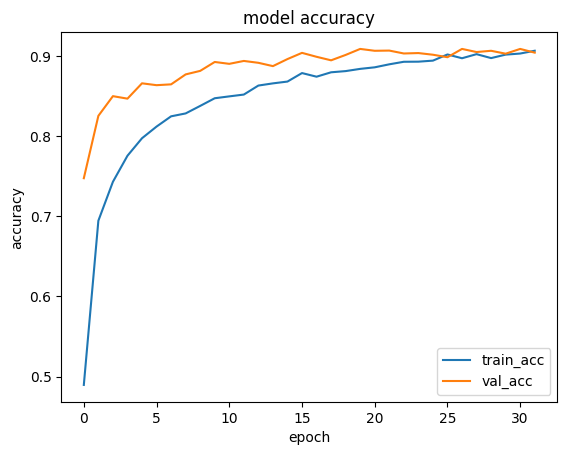

In [ ]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.legend(['train_acc','val_acc'])
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.show()

In [ ]:
model.save('/content/drive/MyDrive/MyFolder/myModelz', save_format="h5")